In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader

# Import de tes modules custom
sys.path.append("..")
from src.data_utils import BrainScanDataset
from src.models import get_brainscan_model
from src.engine import train_one_epoch, evaluate_model
from src.viz_utils import plot_classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Moteur de calcul : {device}")

🚀 Moteur de calcul : cpu


### Stratégie de split

In [2]:
df = pd.read_csv("../data/metadata_with_weak_labels.csv")

# 1. Isolation du Test Set (Uniquement des labels forts, jamais vus)
df_strong_all = df[df["label"] != -1].copy()
df_test = df_strong_all.sample(n=20, random_state=42)
df_train_strong = df_strong_all.drop(df_test.index)

# 2. Le set de Training Faible (les 1406 images issues du clustering)
df_train_weak = df[df["label"] == -1].copy()

# Sauvegarde temporaire pour les DataLoaders
df_test.to_csv("../data/temp_test.csv", index=False)
df_train_strong.to_csv("../data/temp_train_strong.csv", index=False)
df_train_weak.to_csv("../data/temp_train_weak.csv", index=False)

### Préparation des DataLoaders

In [3]:
from torchvision import transforms

# Transformation standard (celle de l'étape 2)
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# DataLoaders
# Note : Pour train_weak, on utilise 'weak_label' généré à l'étape 3
loader_weak = DataLoader(
    BrainScanDataset(
        "../data/temp_train_weak.csv", transform=train_transform, label_col="weak_label"
    ),
    batch_size=32,
    shuffle=True,
)
loader_strong = DataLoader(
    BrainScanDataset(
        "../data/temp_train_strong.csv", transform=train_transform, label_col="label"
    ),
    batch_size=16,
    shuffle=True,
)
loader_test = DataLoader(
    BrainScanDataset(
        "../data/temp_test.csv", transform=train_transform, label_col="label"
    ),
    batch_size=16,
    shuffle=False,
)

### Expérience A - Baseline Supervisée
#### Le modèle apprend uniquement sur les 80 images de Clara.

--- EXPÉRIENCE A : SUPERVISÉ PUR ---


Époque 1 / 10 | Loss: 0.5371


Époque 2 / 10 | Loss: 0.1073


Époque 3 / 10 | Loss: 0.0325


Époque 4 / 10 | Loss: 0.0132


Époque 5 / 10 | Loss: 0.0059


Époque 6 / 10 | Loss: 0.0025


Époque 7 / 10 | Loss: 0.0023


Époque 8 / 10 | Loss: 0.0008


Époque 9 / 10 | Loss: 0.0028


Époque 10 / 10 | Loss: 0.0007


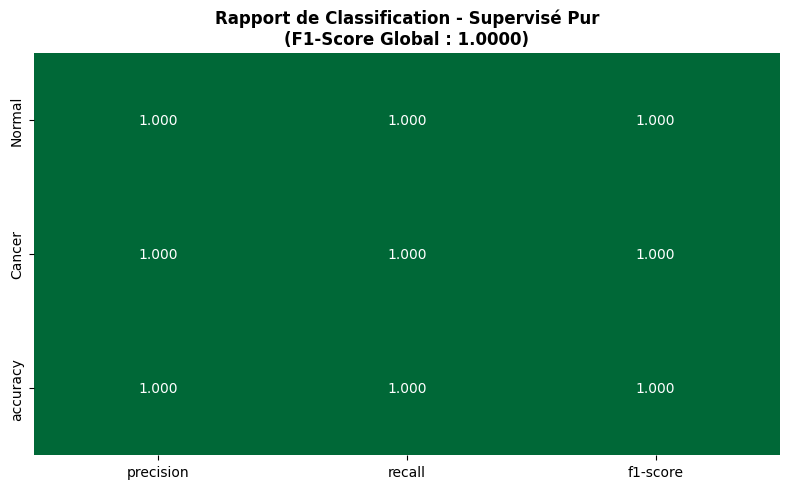

In [5]:
print("--- EXPÉRIENCE A : SUPERVISÉ PUR ---")
model_sup = get_brainscan_model(device=device)
optimizer = optim.Adam(model_sup.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    loss = train_one_epoch(model_sup, loader_strong, optimizer, criterion, device)
    print(f"Époque {epoch + 1} / 10 | Loss: {loss:.4f}")

f1_sup, report_sup = evaluate_model(model_sup, loader_test, device)

# Visualisation des résultats

# Extraction des labels et prédictions
model_sup.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in loader_test:
        images = images.to(device)
        outputs = model_sup(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Heatmap du rapport de classification
plot_classification_report(y_true, y_pred, title="Rapport de Classification - Supervisé Pur", 
                           f1_score=f1_sup)

Taille du dataset : 1506 images


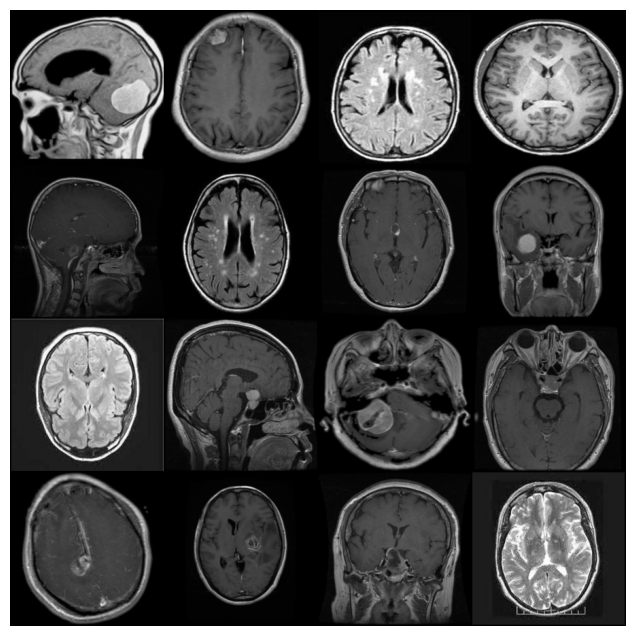

Moyenne (RGB) : tensor([0.2055, 0.2055, 0.2055])
Écart-type (RGB) : tensor([0.1885, 0.1885, 0.1885])


In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Setup des chemins
from src.data_utils import BrainScanDataset
from src.viz_utils import show_batch_grid
from src.stats_utils import compute_dataset_stats

# 1. Initialisation (On transforme juste en Tensor pour l'EDA)
base_transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()]
)

dataset = BrainScanDataset("../data/metadata.csv", transform=base_transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 2. Exécution des tâches A, B et C
print(f"Taille du dataset : {len(dataset)} images")

# Tâche B : Visualisation de la grille
show_batch_grid(loader)

# Tâche C : Calcul des stats (Moyenne & STD)
mean, std = compute_dataset_stats(loader)
print(f"Moyenne (RGB) : {mean}")
print(f"Écart-type (RGB) : {std}")

### Expérience B - Semi-Supervisée (Pseudo-Labeling)
#### Phase 1 sur les labels "faibles", puis Phase 2 sur les labels "forts".

In [ ]:
# --- EXPÉRIENCE B : SEMI-SUPERVISÉ (AVEC LOGGING DES ÉPOQUES) ---
print("--- EXPÉRIENCE B : SEMI-SUPERVISÉ ---")

# 1. Alignement automatique des labels
mapping_counts = pd.crosstab(df_strong_all["label"], df["weak_label"])
correct_label_for_cancer = int(mapping_counts.loc[1].idxmax())

if correct_label_for_cancer == 0:
    print("⚠️ Inversion détectée ! Correction des weak_labels en cours...")
    df["weak_label"] = df["weak_label"].map({0: 1, 1: 0})
else:
    print("✅ Alignement des labels correct.")

# 2. Préparation des loaders
df_train_weak = df[df["label"] == -1].copy()
loader_weak = DataLoader(
    BrainScanDataset(df_train_weak, transform=train_transform, label_col="weak_label"),
    batch_size=32,
    shuffle=True,
)

# 3. Initialisation
model_semi = get_brainscan_model(num_classes=2, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_semi.parameters(), lr=1e-4)

# PHASE 1 : Pré-entraînement (Labels Faibles)
num_epochs_p1 = 5
print(f"\n🚀 Phase 1 : Pre-training ({num_epochs_p1} époques)")
for epoch in range(num_epochs_p1):
    loss = train_one_epoch(model_semi, loader_weak, optimizer, criterion, device)
    # Affichage clair : Epoch 1/5, Epoch 2/5, etc.
    print(f" > Époque [{epoch+1}/{num_epochs_p1}] | Loss Moyenne: {loss:.4f}")

# PHASE 2 : Fine-tuning (Labels Forts)
num_epochs_p2 = 5
print(f"\n🚀 Phase 2 : Fine-tuning ({num_epochs_p2} époques)")
optimizer = optim.Adam(model_semi.parameters(), lr=1e-5)

for epoch in range(num_epochs_p2):
    loss = train_one_epoch(model_semi, loader_strong, optimizer, criterion, device)
    print(f" > Époque [{epoch+1}/{num_epochs_p2}] | Loss Moyenne: {loss:.4f}")

# 4. Évaluation
f1_semi, report_semi = evaluate_model(model_semi, loader_test, device)
print(f"\n📊 Résultat Final Semi-Supervisé : F1 = {f1_semi:.4f}")
print(report_semi)

--- EXPÉRIENCE B : SEMI-SUPERVISÉ ---
⚠️ Inversion détectée ! Correction des weak_labels en cours...

🚀 Phase 1 : Pre-training (5 époques)


 > Époque [1/5] | Loss Moyenne: 0.1245


 > Époque [2/5] | Loss Moyenne: 0.0090


 > Époque [3/5] | Loss Moyenne: 0.0042


 > Époque [4/5] | Loss Moyenne: 0.0009


 > Époque [5/5] | Loss Moyenne: 0.0004

🚀 Phase 2 : Fine-tuning (5 époques)


 > Époque [1/5] | Loss Moyenne: 0.9940


 > Époque [2/5] | Loss Moyenne: 0.6199


 > Époque [3/5] | Loss Moyenne: 0.5107


 > Époque [4/5] | Loss Moyenne: 0.2849


 > Époque [5/5] | Loss Moyenne: 0.1886

📊 Résultat Final Semi-Supervisé : F1 = 0.9333
              precision    recall  f1-score   support

      Normal       0.92      1.00      0.96        12
      Cancer       1.00      0.88      0.93         8

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



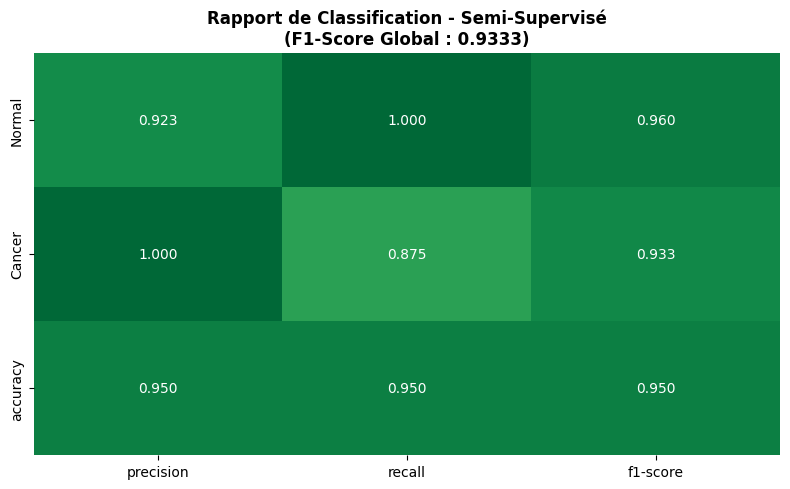

In [8]:
# Visualisation des résultats - Expérience B
# Extraction des labels et prédictions
model_semi.eval()
y_true_semi = []
y_pred_semi = []
with torch.no_grad():
    for images, labels in loader_test:
        images = images.to(device)
        outputs = model_semi(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred_semi.extend(preds)
        y_true_semi.extend(labels.numpy())

# Heatmap du rapport de classification
plot_classification_report(y_true_semi, y_pred_semi, 
                           title="Rapport de Classification - Semi-Supervisé", 
                           f1_score=f1_semi)

### Comparaison des résultats

📊 F1-Score Supervisé : 1.0000
📊 F1-Score Semi-Supervisé : 0.9333

⚠️ Note : Légère baisse de 0.0667 (-6.7%)


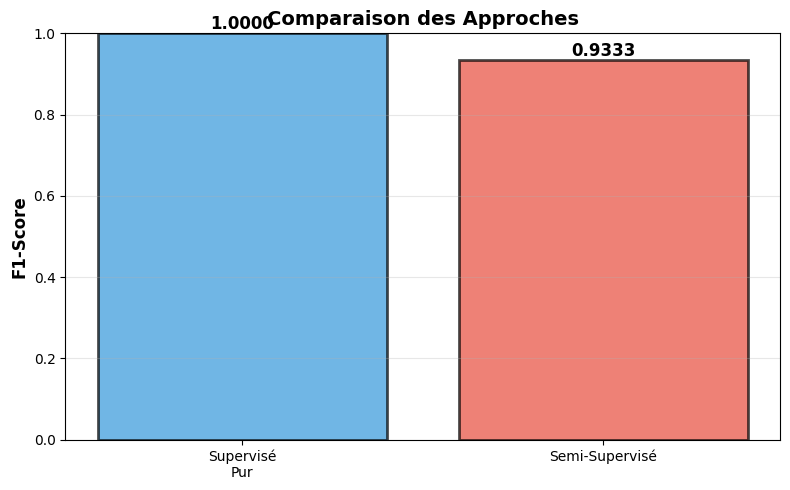

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Résultats numériques
print(f"📊 F1-Score Supervisé : {f1_sup:.4f}")
print(f"📊 F1-Score Semi-Supervisé : {f1_semi:.4f}")

improvement = f1_semi - f1_sup
if f1_semi > f1_sup:
    print(f"\n✅ Succès : Amélioration de {improvement:.4f} (+{improvement/f1_sup*100:.1f}%)")
else:
    print(f"\n⚠️ Note : Légère baisse de {-improvement:.4f} ({improvement/f1_sup*100:.1f}%)")

# Visualisation comparative des F1-Scores
fig, ax = plt.subplots(figsize=(8, 5))
experiments = ["Supervisé\nPur", "Semi-Supervisé"]
scores = [f1_sup, f1_semi]
colors = ["#3498db", "#2ecc71" if f1_semi > f1_sup else "#e74c3c"]

bars = ax.bar(experiments, scores, color=colors, alpha=0.7, edgecolor="black", linewidth=2)

# Ajouter les valeurs sur les barres
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel("F1-Score", fontsize=12, fontweight='bold')
ax.set_title("Comparaison des Approches", fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Vérification du mapping
print(pd.crosstab(df_strong_all["label"], df_strong_all["weak_label"]))

weak_label   0   1
label             
0            2  48
1           38  12
